In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import keras
#mpl.use('pdf')
import sys
sys.path.append("../")
import copy
from Plotting.generate_database import ResultsDatabaseGenerator
from common_packages.utilities import get_equivalent_classical_layer_size, get_num_parameters_per_quantum_layer
from data import generate_synthetic_dataset_easy
from Plotting.Plot import BasicPlot, MultiPlot
tf.compat.v1.enable_eager_execution()
import scipy
import pandas as pd
import seaborn as sns
colors =   ["#5dd448",
            "#bfa900",
            "#ec742f",
            "#e9496f",
            "#b04ca4",]

colors = ["#332288", "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["axes.linewidth"] = 0.5

%load_ext autoreload
%autoreload 2

2023-08-21 17:20:48.326804: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib64:
2023-08-21 17:20:48.326994: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


0.29469538 11.090028 -2.1096597


<Axes: ylabel='Count'>

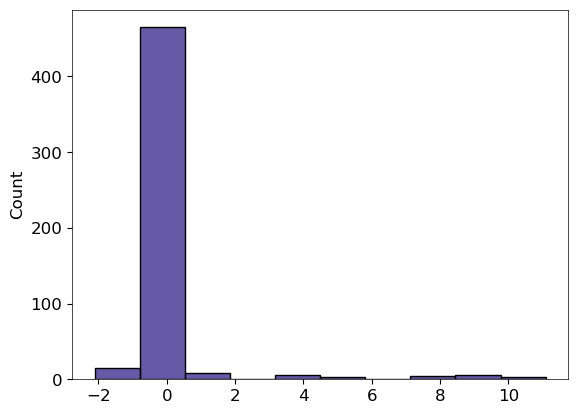

In [132]:
@tf.function
def get_hess(model, inputs, outputs):
    with tf.GradientTape() as t1:
        with tf.GradientTape() as t2:
            t2.watch(model.trainable_variables)
            t1.watch(model.trainable_variables)
            loss = tf.keras.losses.KLDivergence(keras.losses.losses_utils.ReductionV2.NONE)
            loss = loss(outputs, model(inputs))
            grads = t1.gradient(loss, model.trainable_variables[0])
        jac = t2.jacobian(grads, model.trainable_variables[0])
    return grads, jac, loss

tf.random.set_seed(42)

model = keras.Sequential([
    keras.layers.Dense(8, activation='relu', use_bias=False),
    keras.layers.Dense(4, activation='softmax', use_bias=False)])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
(x_train, y_train), (x_test, y_test) = generate_synthetic_dataset_easy(num_datapoints=100, n_features=8, n_classes=4)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

x_test = x_test[y_test[:,0]==1]
y_test = y_test[y_test[:,0]==1]
outputs = model(x_train)
outputs = outputs + np.random.uniform(-0.1,0.1, size=outputs.shape)
grads, jac, loss = get_hess(model, x_train, outputs)
#print(grads, loss)
#print(grads, -jac)

df = pd.DataFrame(columns=['x1', 'x2', 'x3', 'x4', 'y'])
df['x1'] = x_train[:,0]
df['x2'] = x_train[:,1]
df['x3'] = x_train[:,2]
df['x4'] = x_train[:,3]
df['y'] = np.argmax(y_train, axis=1)

eigvals = np.linalg.eigvals(jac).flatten().real
print(np.mean(eigvals), np.max(eigvals), np.min(eigvals))
sns.histplot(eigvals.real, bins=10)